In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T
from tqdm import tqdm
import argparse
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from vpr_model import VPRModel
import faiss
import faiss.contrib.torch_utils
from prettytable import PrettyTable
# from dataloader.GSVCitiesDataset import GSVCitiesDataset 
# Dataloader
from dataloaders.val.NordlandDataset import NordlandDataset
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import os
import PIL.Image as Image
import faiss
import faiss.contrib.torch_utils
from prettytable import PrettyTable

# from dataloaders.val.MapillaryDataset import MSLS
# from dataloaders.val.MapillaryTestDataset import MSLSTest
# from dataloaders.val.PittsburghDataset import PittsburghDataset
# from dataloaders.val.SPEDDataset import SPEDDataset

# VAL_DATASETS = ['MSLS', 'MSLS_Test', 'pitts30k_test', 'pitts250k_test', 'Nordland', 'SPED']
VAL_DATASETS = ['Nordland']


def input_transform(image_size=None):
    MEAN=[0.485, 0.456, 0.406]; STD=[0.229, 0.224, 0.225]
    if image_size:
        return T.Compose([
            T.Resize(image_size,  interpolation=T.InterpolationMode.BILINEAR),
            T.ToTensor(),
            T.Normalize(mean=MEAN, std=STD)
        ])
    else:
        return T.Compose([
            T.ToTensor(),
            T.Normalize(mean=MEAN, std=STD)
        ])

def get_val_dataset(dataset_name, image_size=None):
    dataset_name = dataset_name.lower()
    transform = input_transform(image_size=image_size)
    
    if 'nordland' in dataset_name:    
        ds = NordlandDataset(input_transform=transform)
    # elif 'msls_test' in dataset_name:
    #     ds = MSLSTest(input_transform=transform)

    # elif 'msls' in dataset_name:
    #     ds = MSLS(input_transform=transform)

    # elif 'pitts' in dataset_name:
    #     ds = PittsburghDataset(which_ds=dataset_name, input_transform=transform)

    # elif 'sped' in dataset_name:
    #     ds = SPEDDataset(input_transform=transform)
    else:
        raise ValueError
    
    num_references = ds.num_references
    num_queries = ds.num_queries
    ground_truth = ds.ground_truth
    # print( "==================  label of some place ==================== ")  
    # print( ground_truth[:5][1] ) 
    return ds, num_references, num_queries, ground_truth

def get_descriptors(model, dataloader, device):
    descriptors = []
    with torch.no_grad():
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            for batch in tqdm(dataloader, 'Calculating descritptors...'):
                imgs, labels= batch
                output = model(imgs.to(device)).cpu()
                descriptors.append(output)

    return torch.cat(descriptors)

def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    Giúp khôi phục ảnh từ dạng normalized về dạng hiển thị được (0-1 range).
    """
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # t = t * std + mean
    return torch.clamp(tensor, 0, 1)
    
def load_model(ckpt_path):
    model = VPRModel(
        backbone_arch='dinov2_vitb14',
        backbone_config={
            'num_trainable_blocks': 4,
            'return_token': True,
            'norm_layer': True,
        },
        agg_arch='SALAD',
        agg_config={
            'num_channels': 768,
            'num_clusters': 64,
            'cluster_dim': 128,
            'token_dim': 256,
        },
    )

    # Load checkpoint
    checkpoint = torch.load(ckpt_path, map_location='cpu')
    
    # Lấy đúng phần state_dict bên trong
    model.load_state_dict(checkpoint['state_dict'], strict=False)

    model = model.eval()
    model = model.to('cuda')
    print(f"Loaded model from {ckpt_path} successfully!")
    return model

def parse_args():
    parser = argparse.ArgumentParser(
        description="Eval VPR model",
        formatter_class=argparse.ArgumentDefaultsHelpFormatter
    )
    # Model parameters
    parser.add_argument("--ckpt_path", type=str, required=True, default=None, help="Path to the checkpoint")
    
    # Datasets parameters
    parser.add_argument(
        '--val_datasets',
        nargs='+',
        default=VAL_DATASETS,
        help='Validation datasets to use',
        choices=VAL_DATASETS,
    )
    parser.add_argument('--image_size', nargs='*', default=None, help='Image size (int, tuple or None)')
    parser.add_argument('--batch_size', type=int, default=512, help='Batch size')

    args = parser.parse_args()

    # Parse image size
    if args.image_size:
        if len(args.image_size) == 1:
            args.image_size = (args.image_size[0], args.image_size[0])
        elif len(args.image_size) == 2:
            args.image_size = tuple(args.image_size)
        else:
            raise ValueError('Invalid image size, must be int, tuple or None')
        
        args.image_size = tuple(map(int, args.image_size))

    return args


In [2]:
torch.backends.cudnn.benchmark = True

model = load_model('./logs/lightning_logs/version_60/checkpoints/last.ckpt')        

val_dataset, num_references, num_queries, ground_truth = get_val_dataset('Nordland', [126, 126] )
val_loader = DataLoader(val_dataset, num_workers=16, batch_size=16, shuffle=False, pin_memory=True)

descriptors = get_descriptors(model, val_loader, 'cuda')

r_list = descriptors[ : num_references]

print(f'Evaluating on Nordland')
print(f'Descriptor dimension: {descriptors.shape[1]}')
print(f' reference list dimension:  {r_list.shape}')


faiss_gpu=False

embed_size = r_list.shape[1]
if faiss_gpu:
    res = faiss.StandardGpuResources()
    flat_config = faiss.GpuIndexFlatConfig()
    flat_config.useFloat16 = True
    flat_config.device = 0
    faiss_index = faiss.GpuIndexFlatL2(res, embed_size, flat_config)
# build index
else:
    faiss_index = faiss.IndexFlatL2(embed_size)
# add references
faiss_index.add(r_list)

Using cache found in /home/jupyter-iec_23se07/.cache/torch/hub/facebookresearch_dinov2_main
/home/jupyter-iec_23se07/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/jupyter-iec_23se07/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/jupyter-iec_23se07/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
/tmp/ipykernel_561257/37962485.py:110: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See htt

Loaded model from ./logs/lightning_logs/version_60/checkpoints/last.ckpt successfully!


Calculating descritptors...: 100%|██████████| 1897/1897 [01:06<00:00, 28.39it/s]


Evaluating on Nordland
Descriptor dimension: 8448
 reference list dimension:  torch.Size([27592, 8448])


In [3]:
print(ground_truth) 

[array([0, 1]) array([ 9, 10, 11]) array([19, 20, 21]) ...
 array([27569, 27570, 27571]) array([27579, 27580, 27581])
 array([27589, 27590, 27591])]


Top-4 ảnh giống nhất là (index trong val_dataset): [3863 3865 3889 3882]


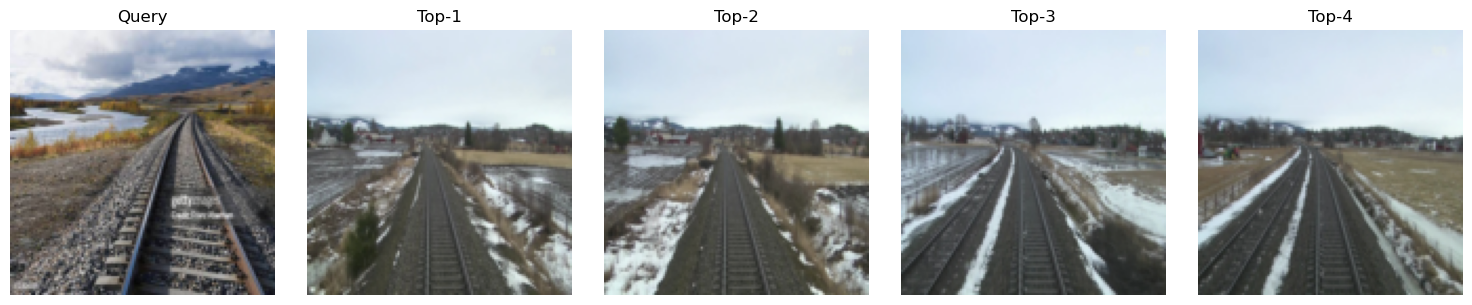

In [4]:

query_image_path = './query_images/i8.jpg'  # ← Thay đường dẫn nếu cần
raw_img = Image.open(query_image_path).convert('RGB')

# === Apply transform giống như với reference ===
transform = input_transform([126, 126])
query_tensor = transform(raw_img).unsqueeze(0).cuda()  # (1, C, H, W)

# === Trích đặc trưng ===
with torch.no_grad():
    with torch.autocast(device_type='cuda', dtype=torch.float16):
        query_descriptor = model(query_tensor).cpu().numpy()  # shape: (1, D)

# === FAISS search: truy vấn với ảnh vừa nhập ===
_, pred_indices = faiss_index.search(query_descriptor, 4)  # top-4

print("Top-4 ảnh giống nhất là (index trong val_dataset):", pred_indices[0])

# === Hiển thị kết quả ===
query_img_show = denormalize(query_tensor.squeeze().cpu())
query_img_show = TF.to_pil_image(query_img_show)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
axes[0].imshow(query_img_show)
axes[0].set_title("Query")
axes[0].axis('off')

for i, idx in enumerate(pred_indices[0]):
    ref_img, _ = val_dataset[idx]
    ref_img = denormalize(ref_img)
    ref_img = TF.to_pil_image(ref_img)
    axes[i+1].imshow(ref_img)
    axes[i+1].set_title(f"Top-{i+1}")
    axes[i+1].axis('off')

plt.tight_layout()
plt.savefig("query_vs_top4_from_image.png")
plt.show()
